In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from saif.crs_model.peakdetector import pk_indxs
import pandas as pd

In [2]:
seismic = pd.read_csv("/Users/pmh/Desktop/temporal_datasets_decatur_illinois_seismic.csv",index_col=None)
pressure = pd.read_csv("/Users/pmh/Desktop/temporal_datasets_decatur_illinois_pressure.csv",index_col=None)

In [3]:
from scipy.interpolate import interp1d
magnitude=pd.DataFrame(seismic['magnitude']).to_numpy().squeeze()
event_times = pd.DataFrame(seismic['epoch']).to_numpy().squeeze()
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times/86400

t_n = (event_times - event_times[0])
t_n=t_n.squeeze()
n_cnts = np.arange(len(t_n))

n_func1 = interp1d(t_n, n_cnts, kind='linear')

In [4]:
t_p = pd.DataFrame(pressure['epoch']).to_numpy().squeeze()
start_idx = np.where(t_p > start_t)[0][0]
end_idx = len(t_p)

end_t=np.where(event_times*86400 > t_p[end_idx-1])[0][0]

t_p=(t_p[start_idx+1:end_idx]-t_p[start_idx+1])/86400
p = pd.DataFrame(pressure['pressure']).to_numpy()[start_idx+1:end_idx].squeeze()
dpdt = pd.DataFrame(pressure['dpdt']).to_numpy()[start_idx+1:end_idx].squeeze()

t_new = np.arange(0,t_p[-1])

delta_t = (t_new[1:] - t_new[:-1])*86400

n_func2 = interp1d(t_p, p, kind='linear')
n_func3 = interp1d(t_p, dpdt, kind='linear')

n_interpolated = n_func1(t_new) # interpolated number of earthquakes 
p_interpolated = n_func2(t_new) # interpolated number of earthquakes 
dpdt_interpolated = n_func3(t_new) # interpolated number of earthquakes 

p_interpolated = torch.FloatTensor(p_interpolated)
dpdt_interpolated = torch.FloatTensor(dpdt_interpolated)
delta_t = torch.FloatTensor(delta_t)
empirical_rate = np.gradient(n_interpolated, t_new)

In [5]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400
site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item(), 
    'mu_minus_alpha_up_limit' : 0.5,
    'rate_coeff_up_limit' : 0.1,
    'rate_factor_up_limit' : 0.002}
trshd=0.70
train_p=888

(0.0, 1000.0)

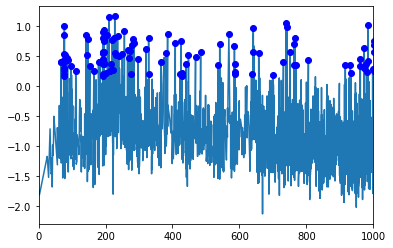

In [6]:
plt.plot((event_times-event_times[0]), magnitude)
peak_indexs=pk_indxs(magnitude[0:end_t],trshd=trshd, min_dist=10)

firstquake=np.where(magnitude > 0.2)[0][0]
peak_indexs=np.insert(peak_indexs,0,firstquake)
   
plt.plot(event_times[peak_indexs]-event_times[0],magnitude[peak_indexs],'o',color='b')

peak_indexs=(np.array((event_times[peak_indexs]-event_times[0])/t_new[-1]*len(t_new),dtype=int))

peak_indexs=np.insert(peak_indexs,0,0)
peak_indexs=np.insert(peak_indexs,np.size(peak_indexs),np.size(t_new)-1)
plt.xlim([0, 1000])

[ 76 193 211 226 278 366 429 441 535 586 641 659 670 701 767]


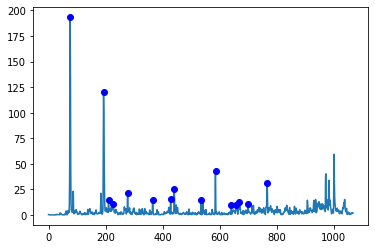

In [7]:
peak_indexs=pk_indxs(empirical_rate[0:train_p],trshd=0.05, min_dist=10)
plt.plot(empirical_rate)
plt.plot(peak_indexs,empirical_rate[peak_indexs],'o',color='b')
print(peak_indexs)

In [8]:
###decide peak
peak_use=[]
for i in peak_indexs:
    low_limit=((np.where(event_times- event_times[0]>i-1)[0][0]))
    high_limit=((np.where(event_times- event_times[0]>i+1)[0][0]))
    if np.max(magnitude[low_limit:high_limit])>((np.max(magnitude)-np.min(magnitude))*trshd+np.min(magnitude)):
       peak_use.append(i)
peak_use=np.insert(peak_use,0,0)
peak_use=np.insert(peak_use,np.size(peak_use),train_p)
print(peak_use)

[  0  76 193 211 226 278 366 429 441 535 586 641 659 701 767 888]


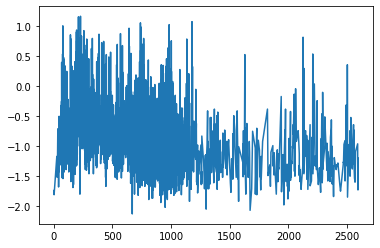

In [9]:
plt.plot(event_times-event_times[0],magnitude)

1069


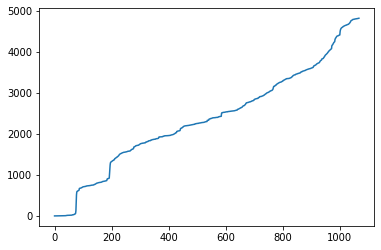

In [10]:
plt.plot(t_new, n_interpolated)
print(len(n_interpolated))

In [11]:
from model import CRSModel
import torch.optim as optim
import torch.nn.functional as F
model = CRSModel(site_info)

params = torch.FloatTensor([[1,0.01,0.01]])

params.requires_grad=True
params.register_hook(lambda g: F.normalize(g))

optimizer = optim.SGD(params=[params],lr=1,momentum=0.1)

criterion = nn.HuberLoss(reduction='mean')
R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])

save_loss=[]

In [12]:
train_loss = []
eval_loss = []

# for i in range(start:0.8* length):
#     train_code
    
# for i in range(0.8*length :end):
#     compute_loss

optimizer = optim.SGD(params=[params],lr=0.01,momentum=0.1)
for epoch in range(500):
    R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])
    for i in range(np.size(peak_use)-1):
             mpa_yr2pa_s = 1e6 / 365.25 / 86400
             site_info = {
                          'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
                          'tectonic_normal_stressing_rate' : 0, # Pa/s
                          'sigma' : 30 * 1e6, # Pa
                          'biot' : 0.3, # dimensionless
                          #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
                          'background_rate' : empirical_rate[peak_use[i]]/ 86400, # event/second,
                          'init_delta_t' : delta_t[0].item(),    
                          'mu_minus_alpha_up_limit':0.5,
                          'rate_coeff_up_limit': 0.1,
                          'rate_factor_up_limit': 0.002}
             model = CRSModel(site_info)
             p0 = torch.FloatTensor(p_interpolated)[peak_use[i]+1:peak_use[i+1]]
             dpdt0 = torch.FloatTensor(dpdt_interpolated)[peak_use[i]+1:peak_use[i+1]]
             delta_t0 = torch.FloatTensor(delta_t)[peak_use[i]+1:peak_use[i+1]]
             Rt, Nt = model(params, p0, dpdt0, delta_t0)
             R0=torch.cat((R0,Rt),dim=-1)
             #print(N0.detach()[0][-1])
             Nt=torch.add(Nt,N0.detach()[0][-1])
             #print(N0.detach())
             N0=torch.cat((N0,Nt),dim=-1)
             n_target= torch.FloatTensor(n_interpolated)[peak_use[i]:peak_use[i+1]]
             n_target0=torch.cat((n_target0,n_target),dim=-1)
             #print(n_target0.detach().size(),(N0[:,1:]).squeeze().detach().size())

    # loss = criterion(Nt[:,1:], n_target[None,:]) # Need to define a loss function that compares with the real data
    # Define a MSE of forecasted number Nt with the ground truth
    
    loss1 = criterion((N0[:,1:]).squeeze(), n_target0) 
    print('loss is ' + str(loss1.item()))
    train_loss.append(loss1.item())
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    Nt.shape
    #######
    p_eval = torch.FloatTensor(p_interpolated)[train_p:len(delta_t)]
    dpdt_eval = torch.FloatTensor(dpdt_interpolated)[train_p:len(delta_t)]
    delta_eval = torch.FloatTensor(delta_t)[train_p:len(delta_t)]
    n_target_eval= torch.FloatTensor(n_interpolated)[train_p:len(delta_t)]
    
    R_eval, N_eval = model(params.data, p_eval, dpdt_eval, delta_eval)
    loss2 = criterion((N_eval[:,1:]).squeeze()+N0.detach()[0][-1], n_target_eval)
    eval_loss.append(loss2.item())

loss is 6201.5634765625
loss is 6176.5654296875
loss is 6149.4619140625
loss is 6122.1630859375
loss is 6094.40771484375
loss is 6066.56005859375
loss is 6038.771484375


KeyboardInterrupt: 

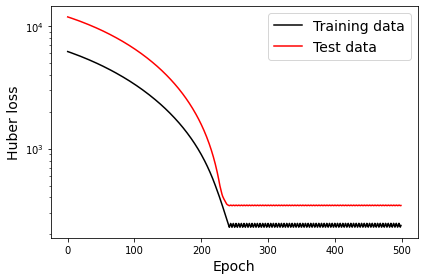

In [82]:
fig = plt.figure()
#n_epoch = np.arange(300) + 1
plt.plot( train_loss, '-k',  label='Training data')
plt.plot( eval_loss, '-r',  label='Test data')
plt.gca().set_yscale('log')
plt.legend(loc='best', prop={'size':14})
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Huber loss', fontsize=14)
plt.tight_layout()
plt.show()

In [83]:
p0 = torch.FloatTensor(p_interpolated)[peak_use[i+1]+1:]
dpdt0 = torch.FloatTensor(dpdt_interpolated)[peak_use[i+1]+1:]
delta_t0 = torch.FloatTensor(delta_t)[peak_use[i+1]:]
Rt_pre, Nt_pre = model(params, p0, dpdt0, delta_t0)

tensor(0.3687) tensor(0.0126) tensor(0.0003)


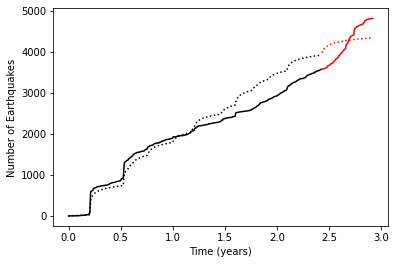

In [84]:
plt.plot(t_new[0:train_p]/365.25,(N0[:,1:]).squeeze().detach().numpy(),':k')
plt.plot(t_new[train_p+1:]/365.25,(Nt_pre[:,1:]+N0.detach()[0][-1]).squeeze().detach().numpy(),':r')
plt.plot(t_new[0:train_p]/365.25,n_interpolated[0:train_p],'-k')
plt.plot(t_new[train_p+1:]/365.25,n_interpolated[train_p+1:],'-r')
plt.xlabel("Time (years)")
plt.ylabel("Number of Earthquakes")
print((torch.sigmoid(params.data[0][0])*0.5),(torch.sigmoid(params.data[0][1])*0.1),(torch.sigmoid(params.data[0][2])*0.002))